In [5]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/toxic-comment/sample_submission.csv
/kaggle/input/toxic-comment/all_data.csv
/kaggle/input/toxic-comment/test_public_expanded.csv
/kaggle/input/toxic-comment/test_private_expanded.csv
/kaggle/input/toxic-comment/toxicity_individual_annotations.csv
/kaggle/input/toxic-comment/train.csv
/kaggle/input/toxic-comment/identity_individual_annotations.csv
/kaggle/input/toxic-comment/test.csv


In [6]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import re
from wordcloud import WordCloud, STOPWORDS
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer, PorterStemmer
import math
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, auc, mean_squared_error
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
import gensim
import string
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
import keras
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
import warnings
from keras import backend as K
warnings.filterwarnings("ignore")


In [7]:
train_df = pd.read_csv('/kaggle/input/toxic-comment/train.csv')
train_df.head(5)

,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,...,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
0,59848,0.000000,"This is so cool. It's like, 'would you want yo...",0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
1,59849,0.000000,Thank you!! This would make my life a lot less...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
2,59852,0.000000,This is such an urgent design problem; kudos t...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
3,59855,0.000000,Is this something I'll be able to install on m...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
4,59856,0.893617,haha you guys are a bunch of losers.,0.021277,0.0,0.021277,0.87234,0.0,0.0,0.0,...,2006,rejected,0,0,0,1,0,0.0,4,47


In [8]:
test_df = pd.read_csv('/kaggle/input/toxic-comment/test.csv')
test_df.head(5)

,id,comment_text
0,7097320,[ Integrity means that you pay your debts.]\n\...
1,7097321,This is malfeasance by the Administrator and t...
2,7097322,@Rmiller101 - Spoken like a true elitist. But ...
3,7097323,"Paul: Thank you for your kind words. I do, in..."
4,7097324,Sorry you missed high school. Eisenhower sent ...


**Exploratory Data Analysis**

In [9]:
train_df.describe()

,id,target,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,bisexual,...,parent_id,article_id,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
count,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,405130.000000,405130.000000,405130.000000,...,1.026228e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06
mean,3.738434e+06,1.030173e-01,4.582099e-03,1.387721e-02,2.263571e-02,8.115273e-02,9.311271e-03,0.011964,0.003205,0.001884,...,3.722687e+06,2.813597e+05,2.779269e-01,4.420696e-02,1.091173e-01,2.446167e+00,5.843688e-01,6.605974e-03,1.439019e+00,8.784694e+00
std,2.445187e+06,1.970757e-01,2.286128e-02,6.460419e-02,7.873156e-02,1.760657e-01,4.942218e-02,0.087166,0.050193,0.026077,...,2.450261e+06,1.039293e+05,1.055313e+00,2.449359e-01,4.555363e-01,4.727924e+00,1.866589e+00,4.529782e-02,1.787041e+01,4.350086e+01
min,5.984800e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,...,6.100600e+04,2.006000e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.000000e+00
25%,7.969752e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,...,7.960188e+05,1.601200e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.000000e+00
50%,5.223774e+06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,...,5.222993e+06,3.321260e+05,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.000000e+00
75%,5.769854e+06,1.666667e-01,0.000000e+00,0.000000e+00,0.000000e+00,9.090909e-02,0.000000e+00,0.000000,0.000000,0.000000,...,5.775758e+06,3.662370e+05,0.000000e+00,0.000000e+00,0.000000e+00,3.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.000000e+00
max,6.334010e+06,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000,1.000000,1.000000,...,6.333965e+06,3.995410e+05,1.020000e+02,2.100000e+01,3.100000e+01,3.000000e+02,1.870000e+02,1.000000e+00,1.866000e+03,4.936000e+03


In [10]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1804874 entries, 0 to 1804873
Data columns (total 45 columns):
 #   Column                               Dtype  
---  ------                               -----  
 0   id                                   int64  
 1   target                               float64
 2   comment_text                         object 
 3   severe_toxicity                      float64
 4   obscene                              float64
 5   identity_attack                      float64
 6   insult                               float64
 7   threat                               float64
 8   asian                                float64
 9   atheist                              float64
 10  bisexual                             float64
 11  black                                float64
 12  buddhist                             float64
 13  christian                            float64
 14  female                               float64
 15  heterosexual                    

In [11]:
#checking for null values
train_df.isnull().sum()

id                                           0
target                                       0
comment_text                                 3
severe_toxicity                              0
obscene                                      0
identity_attack                              0
insult                                       0
threat                                       0
asian                                  1399744
atheist                                1399744
bisexual                               1399744
black                                  1399744
buddhist                               1399744
christian                              1399744
female                                 1399744
heterosexual                           1399744
hindu                                  1399744
homosexual_gay_or_lesbian              1399744
intellectual_or_learning_disability    1399744
jewish                                 1399744
latino                                 1399744
male         

In [12]:
print("Train and test shape : {}{}".format(train_df.shape , test_df.shape) )

Train and test shape : (1804874, 45)(97320, 2)


#  **EXPLORATORY DATA ANALYSIS**

**1.TARGET FEATURE**

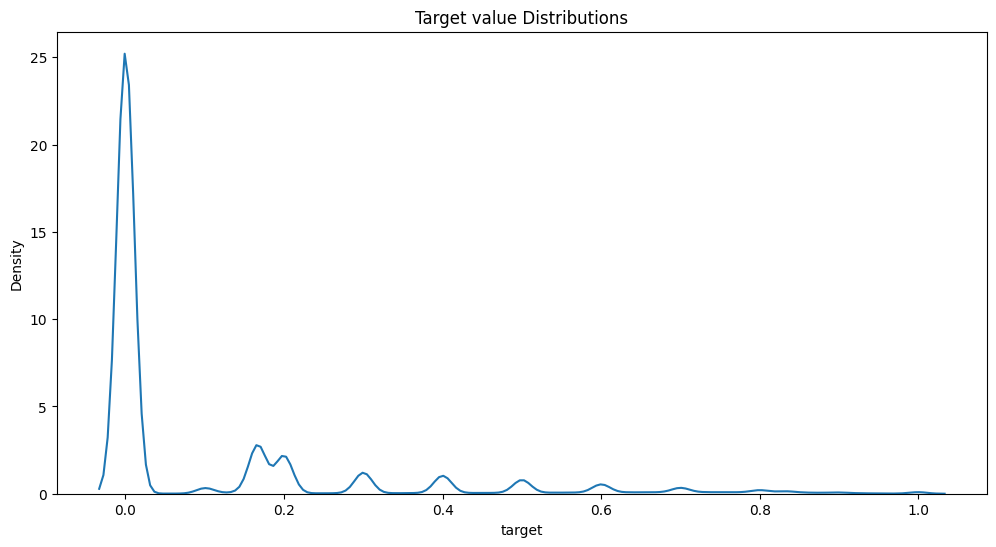

In [13]:
plt.figure(figsize=(12,6))
plt.title("Target value Distributions")
sns.distplot(train_df['target'], kde=True, hist=False, bins=240, label='target')
plt.show()

**We see that most of the comments present in the dataset are actually non-toxic (<0.5) and only a few of them are actually toxic (>0.5)**

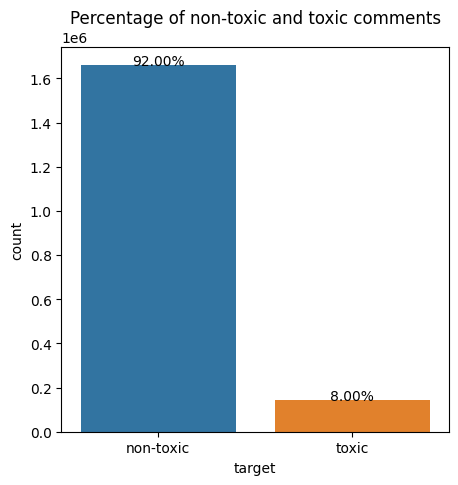

In [14]:
temp = train_df['target'].apply(lambda x: "non-toxic" if x < 0.5 else "toxic")
fig, ax = plt.subplots(figsize=(5,5))
cntplot = sns.countplot(x=temp)
cntplot.set_title('Percentage of non-toxic and toxic comments')
total = float(len(temp))  

for p in cntplot.patches:
    height = p.get_height()
    cntplot.text(p.get_x() + p.get_width() / 2., height + 3, '{:1.2f}%'.format(100 * height / total), ha="center")

plt.show()


**The dataset is imbalanced as 92% of the comments are non-toxic and only 8% are toxic**

In [15]:
def get_comment_nature(row):
    categories = ['severe_toxicity', 'obscene', 'identity_attack', 'insult', 'threat']
    values = [row[category] for category in categories]
    max_index = np.argmax(values)
    return categories[max_index]

**2.Toxicity Feature**
* severe_toxicity
* obscene
* threat
* insult
* identity_attack


In [16]:
def plot_feature_distribution(feature,title,data):
    plt.figure(figsize=(12,6))
    plt.title(title)
    for feature in features:
        sns.distplot(data[feature],kde=True,hist=False, bins=240, label=feature)
    plt.xlabel('')
    plt.legend()
    plt.show()
    

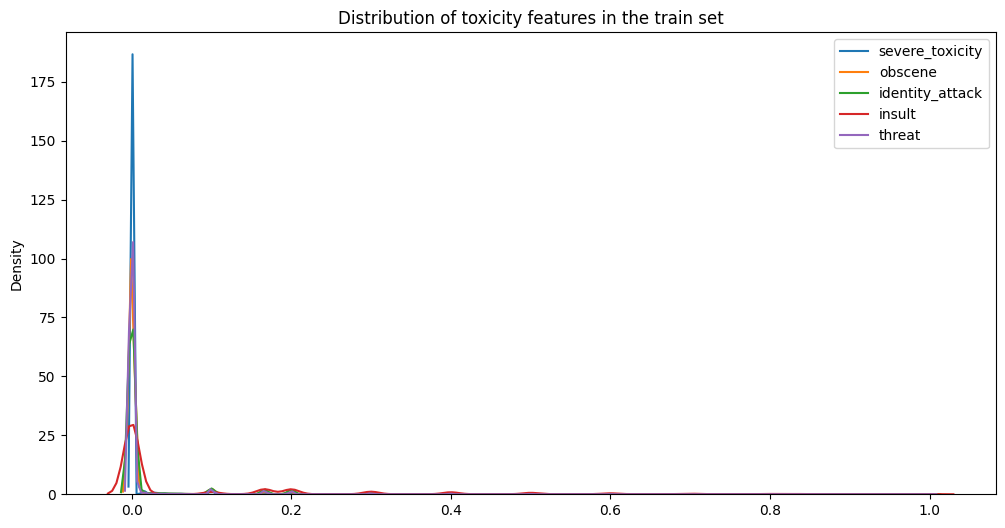

In [17]:
features=['severe_toxicity', 'obscene', 'identity_attack', 'insult', 'threat']
plot_feature_distribution(features,"Distribution of toxicity features in the train set",train_df)

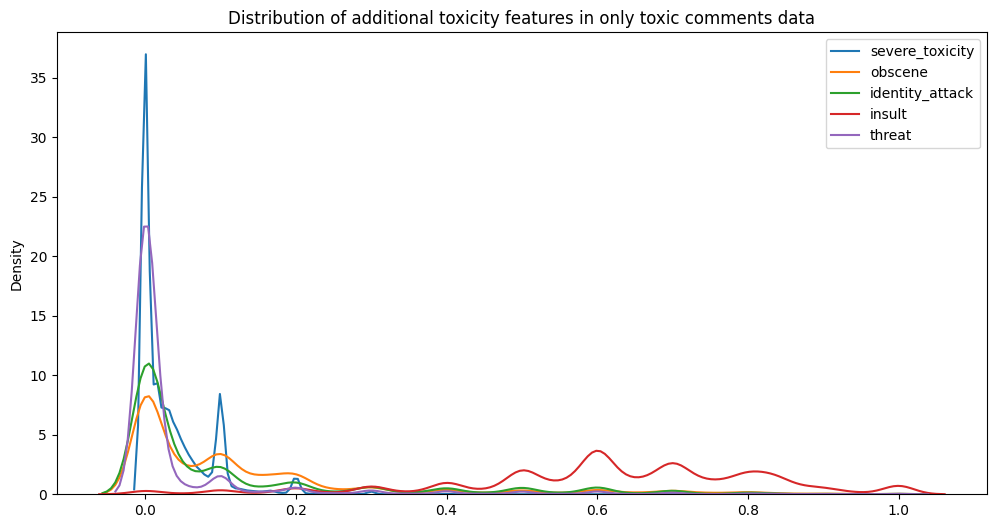

In [18]:
# Looking at the distribution of additional toxicity features on the comments that are actually considered toxic:
temp = train_df[train_df['target'] > 0.5]
plot_feature_distribution(features, "Distribution of additional toxicity features in only toxic comments data", temp)

**We see that for toxic comments data, there are more insulting comments as compared to obscene comments**

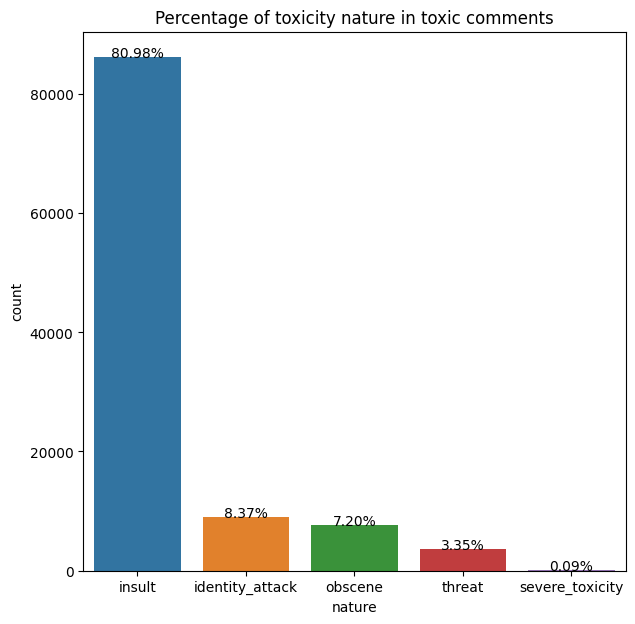

In [19]:
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
import seaborn as sns
import matplotlib.pyplot as plt

def get_comment_nature(row):
    categories = ['severe_toxicity', 'obscene', 'identity_attack', 'insult', 'threat']
    available_categories = [category for category in categories if category in row.index]
    if not available_categories:
        return 'unknown'
    values = [row[category] for category in available_categories]
    max_index = np.argmax(values)
    return available_categories[max_index]

# Assuming 'temp' is your DataFrame containing the comment data

# Select only numerical columns for imputation
numerical_temp = temp.select_dtypes(include=[np.number])

# Handling missing values using SimpleImputer
imputer = SimpleImputer(strategy='mean')  # You can change the strategy as needed
temp_imputed = pd.DataFrame(imputer.fit_transform(numerical_temp), columns=numerical_temp.columns, index=numerical_temp.index)

# Applying the function to create a new column 'nature'
temp_imputed['nature'] = temp_imputed.apply(get_comment_nature, axis=1)

# Plotting
fig, ax = plt.subplots(figsize=(7, 7))
total = len(temp_imputed['nature'])
counts = temp_imputed['nature'].value_counts()

sns.countplot(x='nature', data=temp_imputed, order=counts.index)
plt.title('Percentage of toxicity nature in toxic comments')

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height + 3, '{:1.2f}%'.format(100 * height / total), ha="center")

plt.show()



**In our train dataset only 8% of the data was toxic. Out of that 8%, 81% of the toxic comments made are insults, 8.37% are identity attacks, 7.20% are obscene, 3.35% are threats and a very small amount of toxic comments are severly toxic.**

**3.IDENTITY ATTRIBUTES**

Sensitive topics:
* male
* female
* homosexual_gay_or_lesbian
* bisexual
* heterosexual
* christian
* jewish
* muslim
* black
* white
* asian
* latino

In [20]:
temp = train_df.dropna(axis = 0, how = 'any')

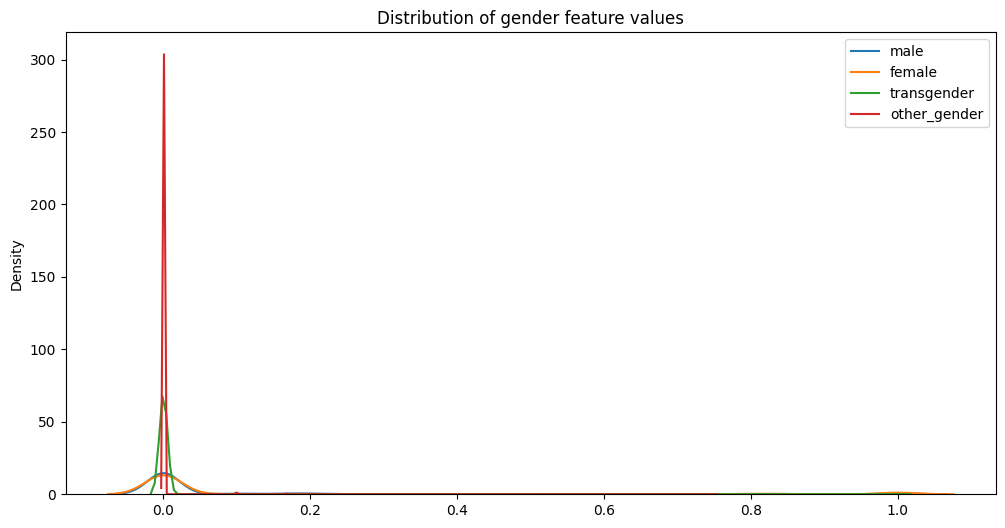

In [21]:
features = ['male', 'female', 'transgender', 'other_gender']
plot_feature_distribution(features, "Distribution of gender feature values", temp)

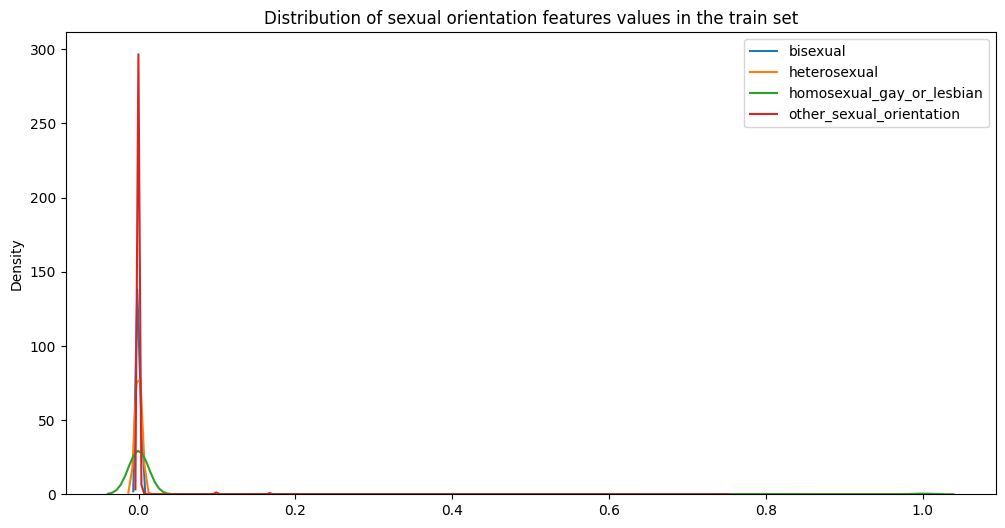

In [22]:
features = ['bisexual', 'heterosexual', 'homosexual_gay_or_lesbian', 'other_sexual_orientation']
plot_feature_distribution(features, "Distribution of sexual orientation features values in the train set", temp)

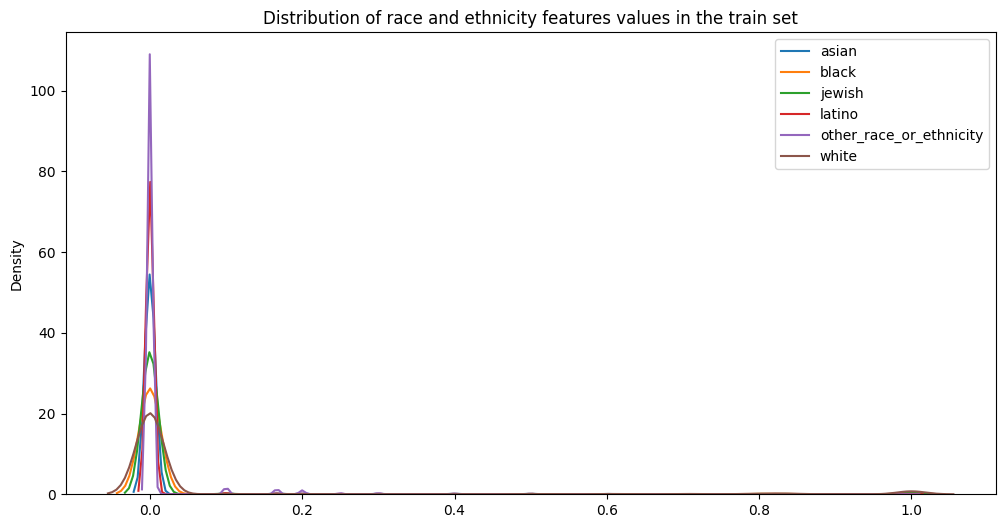

In [23]:
features = ['asian', 'black', 'jewish', 'latino', 'other_race_or_ethnicity', 'white']
plot_feature_distribution(features, "Distribution of race and ethnicity features values in the train set", temp)

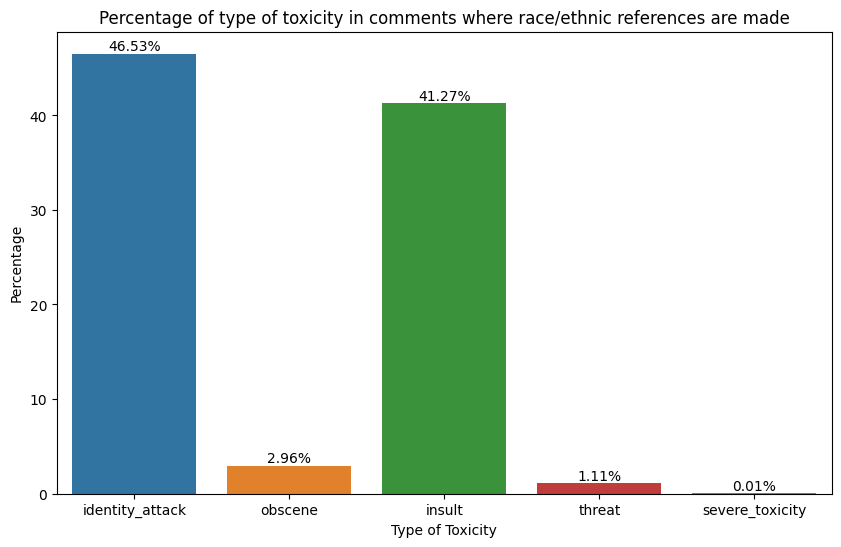

In [24]:

cond = (train_df['asian'] > 0.5) | (train_df['black'] > 0.5) | (train_df['jewish'] > 0.5) | (train_df['latino'] > 0.5) | (train_df['white'] > 0.5)
filtered_comments = train_df[cond]
toxic_comments = filtered_comments[filtered_comments['target'] > 0.5]
total_toxic_comments = len(toxic_comments)
toxic_types = ['identity_attack', 'obscene', 'insult', 'threat', 'severe_toxicity']
toxic_percentages = {}
for toxic_type in toxic_types:
    percentage = (toxic_comments[toxic_type] > 0.5).sum() / total_toxic_comments * 100
    toxic_percentages[toxic_type] = percentage


plt.figure(figsize=(10, 6))
barplot = sns.barplot(x=list(toxic_percentages.keys()), y=list(toxic_percentages.values()))
plt.title('Percentage of type of toxicity in comments where race/ethnic references are made')
plt.xlabel('Type of Toxicity')
plt.ylabel('Percentage')


for p in barplot.patches:
    barplot.annotate(f'{p.get_height():.2f}%', 
                     (p.get_x() + p.get_width() / 2., p.get_height()), 
                     ha='center', va='center', fontsize=10, color='black', xytext=(0, 5), 
                     textcoords='offset points')

plt.show()


**We see that the toxic comments involving words like black, asian etc. are mainly used for identity attacks or insults.**

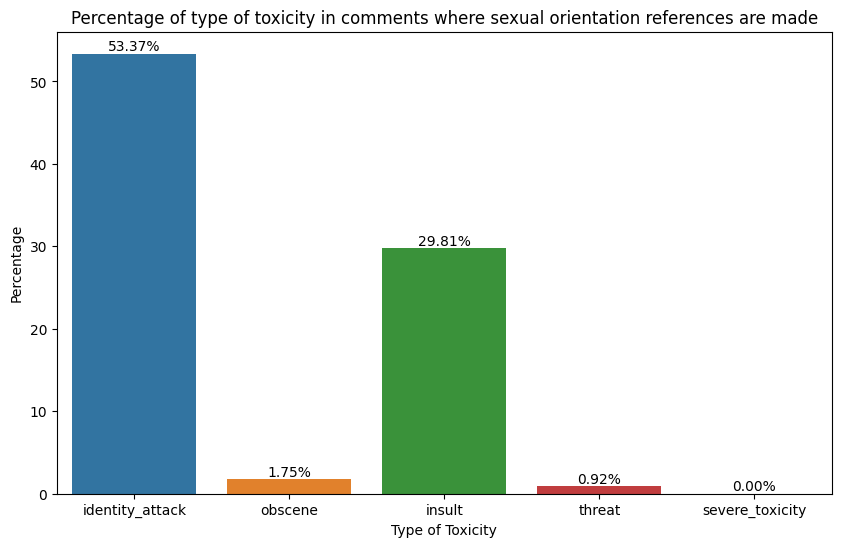

In [25]:
cond = (train_df['bisexual'] > 0.5) | (train_df['heterosexual'] > 0.5) | (train_df['homosexual_gay_or_lesbian'] > 0.5) | (train_df['other_sexual_orientation'] > 0.5) 
filtered_comments = train_df[cond]
toxic_comments = filtered_comments[filtered_comments['target'] > 0.5]
total_toxic_comments = len(toxic_comments)
toxic_types = ['identity_attack', 'obscene', 'insult', 'threat', 'severe_toxicity']
toxic_percentages = {}
for toxic_type in toxic_types:
    percentage = (toxic_comments[toxic_type] > 0.5).sum() / total_toxic_comments * 100
    toxic_percentages[toxic_type] = percentage


plt.figure(figsize=(10, 6))
barplot = sns.barplot(x=list(toxic_percentages.keys()), y=list(toxic_percentages.values()))
plt.title('Percentage of type of toxicity in comments where sexual orientation references are made')
plt.xlabel('Type of Toxicity')
plt.ylabel('Percentage')


for p in barplot.patches:
    barplot.annotate(f'{p.get_height():.2f}%', 
                     (p.get_x() + p.get_width() / 2., p.get_height()), 
                     ha='center', va='center', fontsize=10, color='black', xytext=(0, 5), 
                     textcoords='offset points')


**We see from the plot that the toxic comments where sexual orientation references are made are mostly used for identity attacks.**

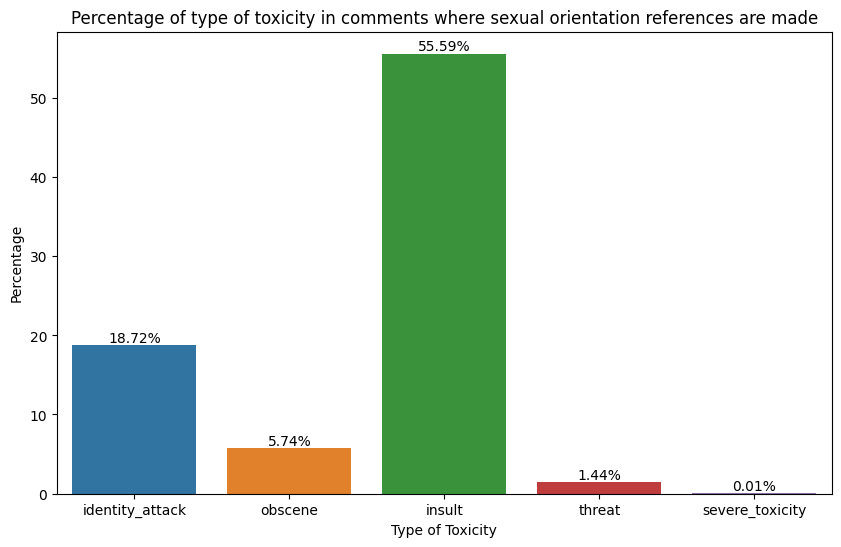

In [26]:
cond = (train_df['male'] > 0.5) | (train_df['female'] > 0.5) | (train_df['transgender'] > 0.5) | (train_df['other_gender'] > 0.5)
filtered_comments = train_df[cond]
toxic_comments = filtered_comments[filtered_comments['target'] > 0.5]
total_toxic_comments = len(toxic_comments)
toxic_types = ['identity_attack', 'obscene', 'insult', 'threat', 'severe_toxicity']
toxic_percentages = {}
for toxic_type in toxic_types:
    percentage = (toxic_comments[toxic_type] > 0.5).sum() / total_toxic_comments * 100
    toxic_percentages[toxic_type] = percentage


plt.figure(figsize=(10, 6))
barplot = sns.barplot(x=list(toxic_percentages.keys()), y=list(toxic_percentages.values()))
plt.title('Percentage of type of toxicity in comments where sexual orientation references are made')
plt.xlabel('Type of Toxicity')
plt.ylabel('Percentage')


for p in barplot.patches:
    barplot.annotate(f'{p.get_height():.2f}%', 
                     (p.get_x() + p.get_width() / 2., p.get_height()), 
                     ha='center', va='center', fontsize=10, color='black', xytext=(0, 5), 
                     textcoords='offset points')


**From the plot we see that the toxic comments which involve words like male, female etc are insults.**

**4. Features generated by users feedback:**

* funny
* sad
* wow
* likes
* disagree

In [27]:
 def plot_count(feature, title, data, size=1):
    if isinstance(data, pd.DataFrame):
        if feature in data.columns:
            plt.figure(figsize=(8*size, 6))
            g = sns.countplot(data=data, x=feature, order=data[feature].value_counts().index[:20], palette='Set3')
            g.set_title("Number and percentage of {}".format(title))
            total = len(data)
            for p in g.patches:
                height = p.get_height()
                g.text(p.get_x() + p.get_width() / 2., height + 10, '{:1.2f}%'.format(100 * height / total), ha="center")
            plt.yticks(fontsize=10)
            plt.xticks(fontsize=10)
            plt.show()
        else:
            print("Specified feature '{}' does not exist in the DataFrame.".format(feature))
    else:
        print("Input data must be a pandas DataFrame.")

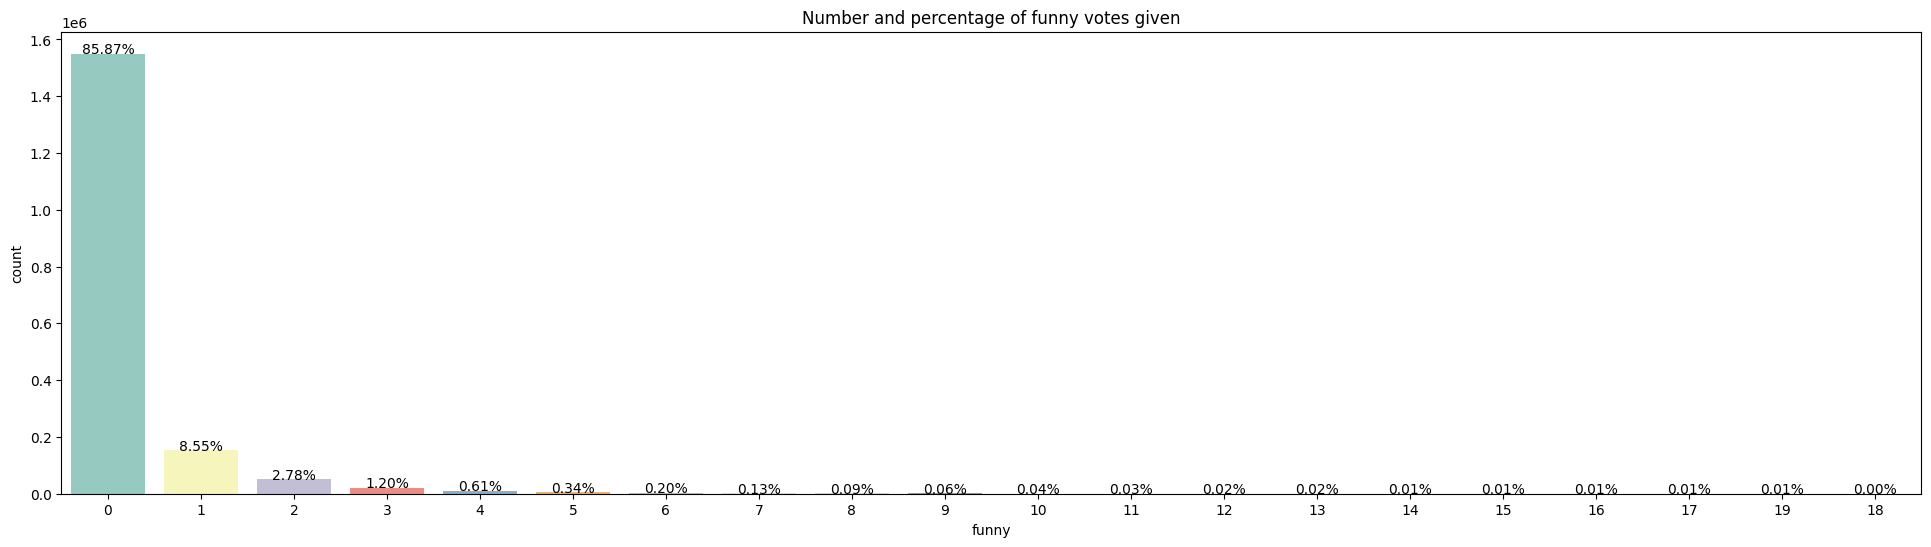

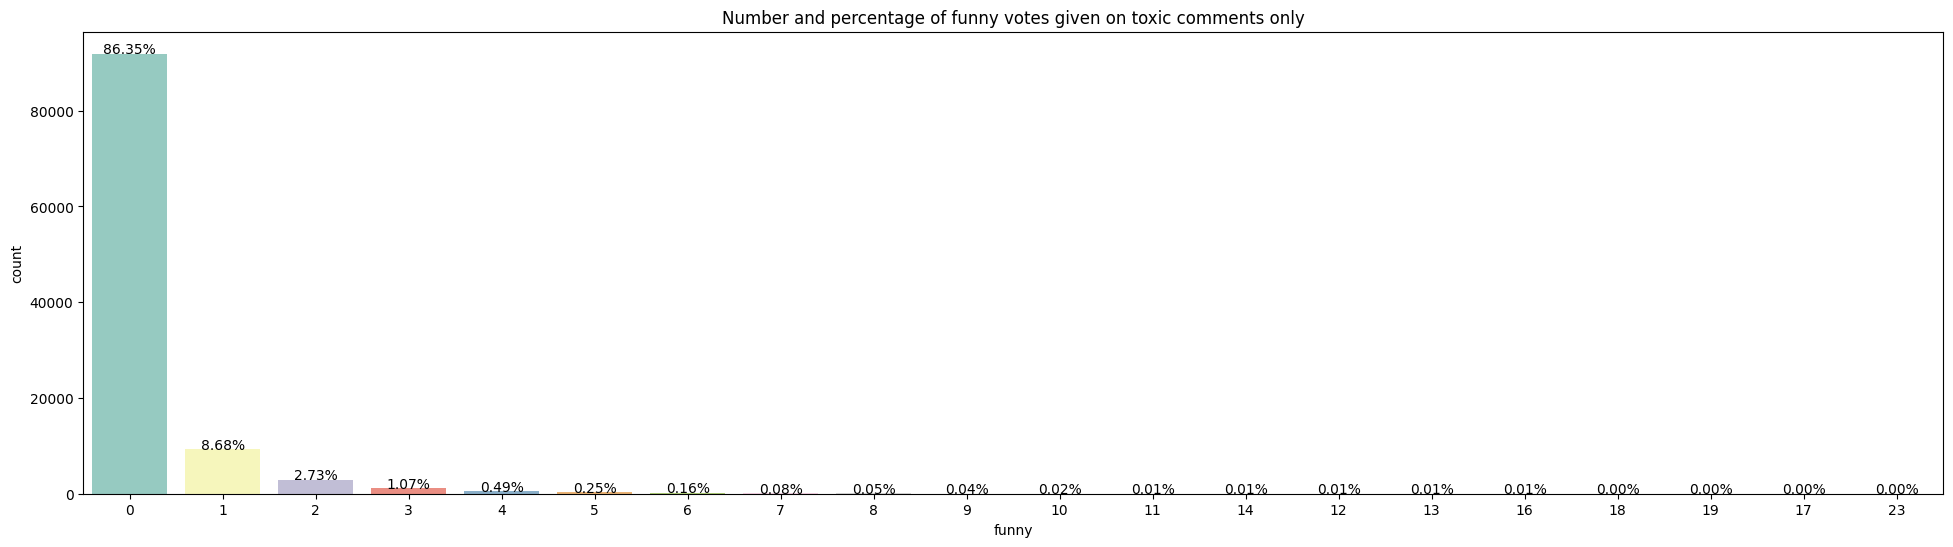

In [28]:

plot_count('funny', 'funny votes given', train_df, 3)
plot_count('funny', 'funny votes given on toxic comments only', train_df[train_df['target'] > 0.5], 3)



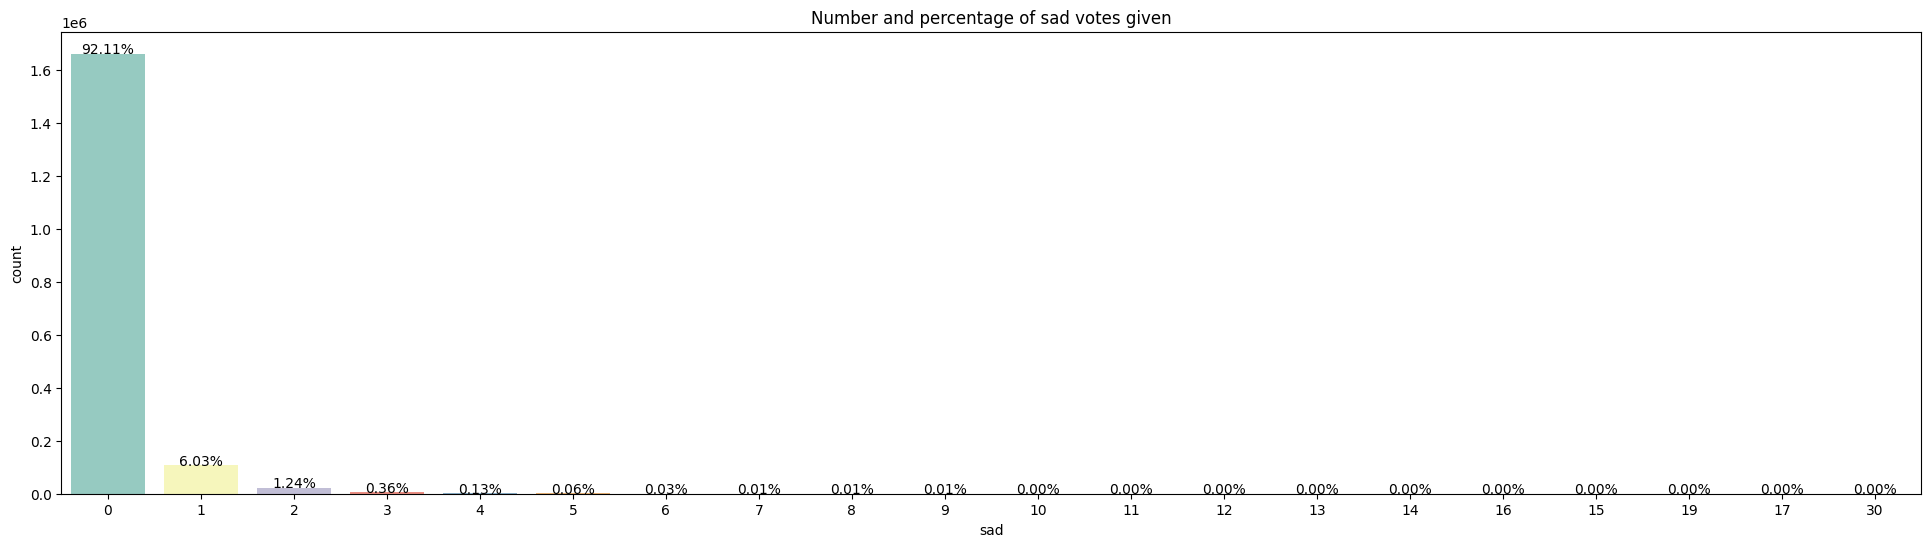

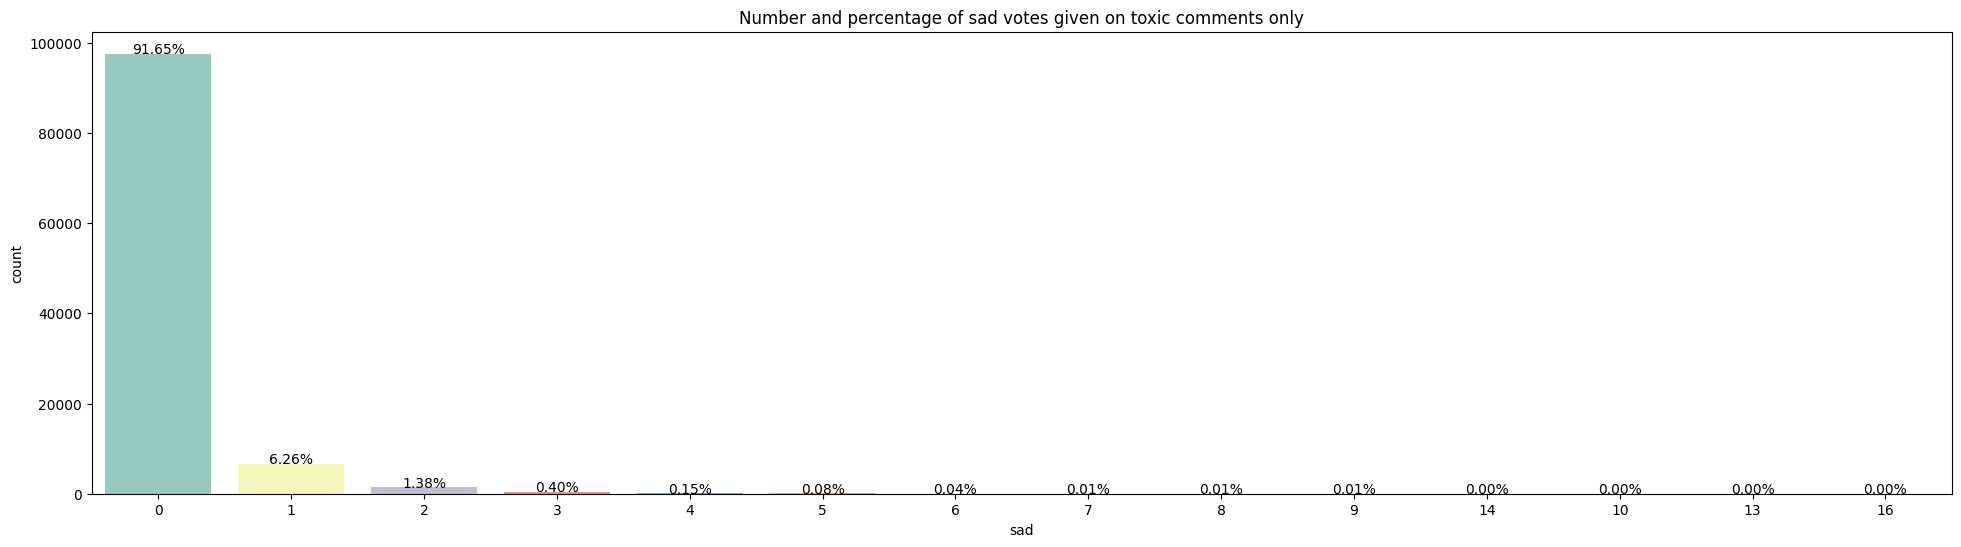

In [29]:
plot_count('sad','sad votes given', train_df, 3)
plot_count('sad', 'sad votes given on toxic comments only', train_df[train_df['target'] > 0.5], 3)

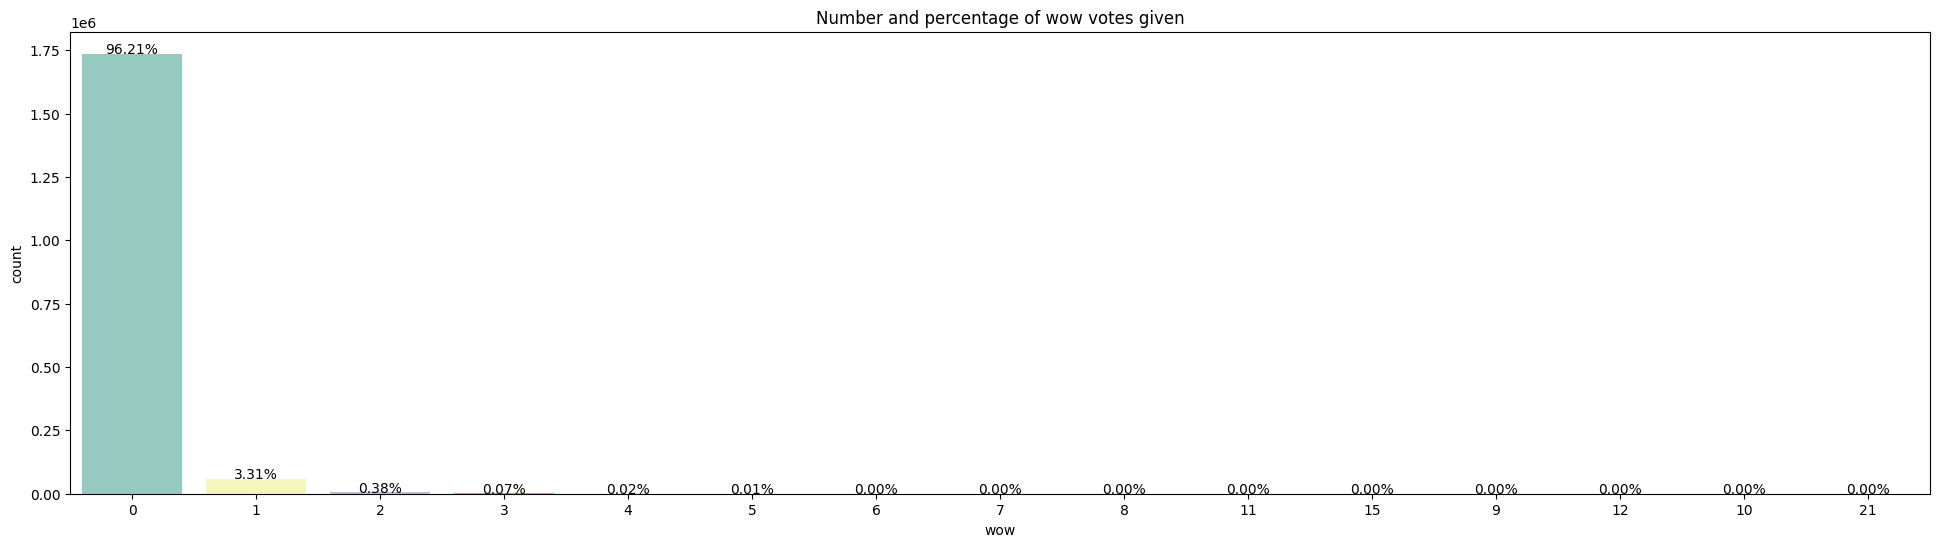

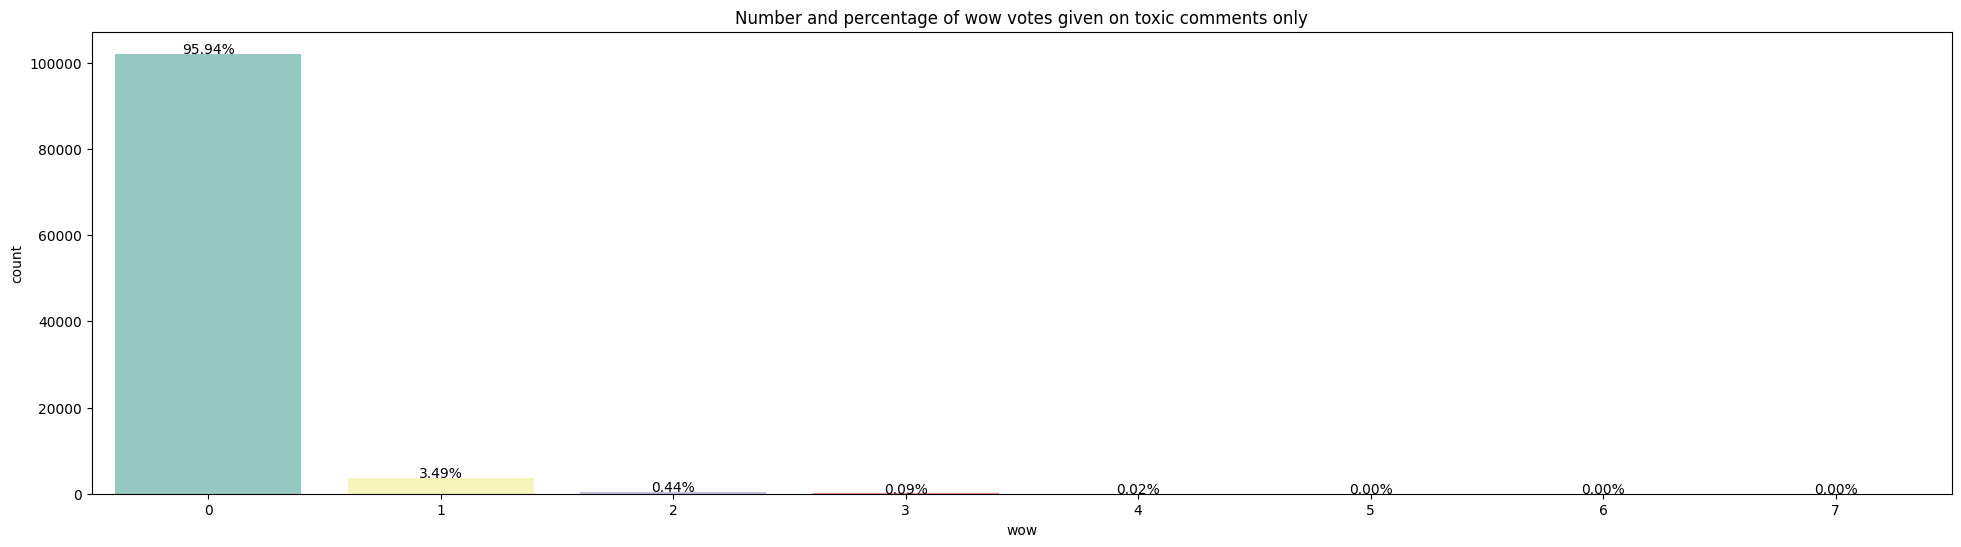

In [30]:
plot_count('wow','wow votes given', train_df, 3)
plot_count('wow', 'wow votes given on toxic comments only', train_df[train_df['target'] > 0.5], 3)

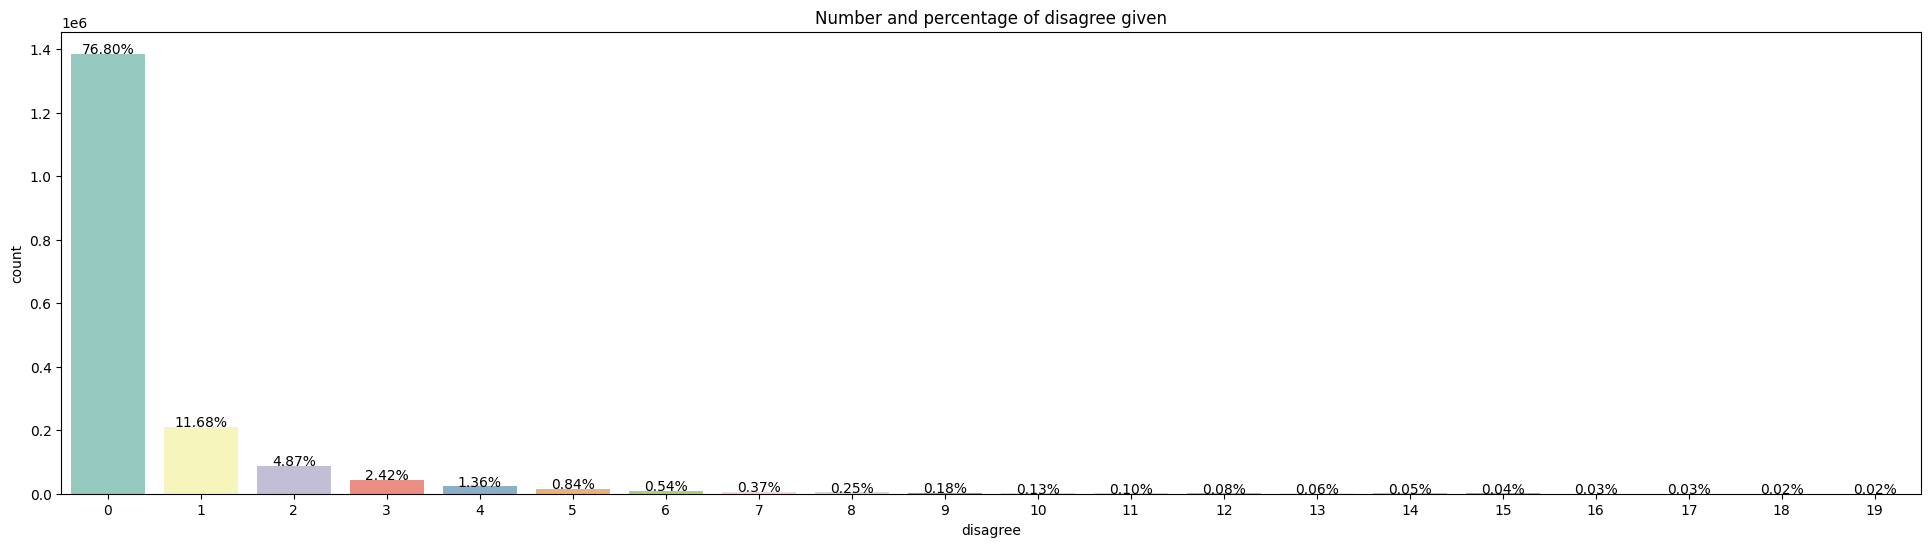

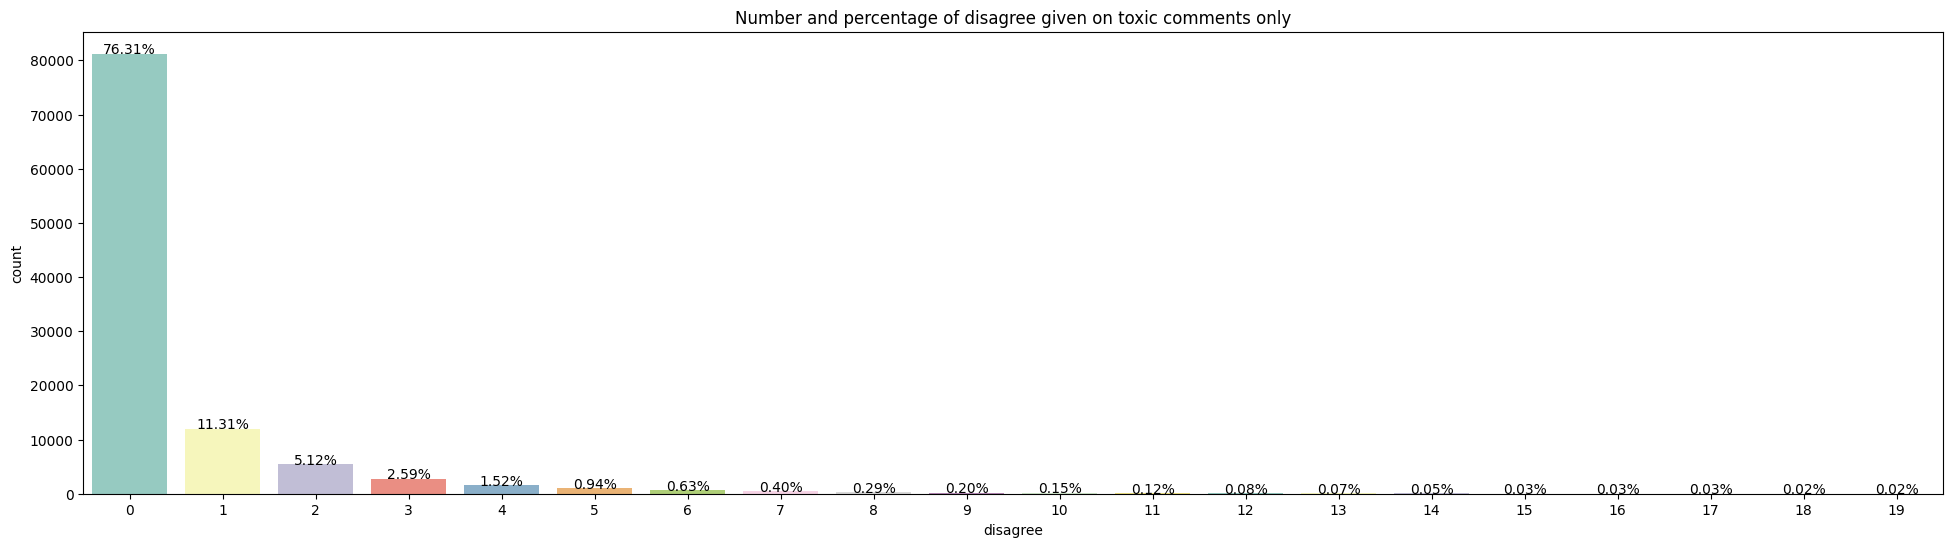

In [31]:
plot_count('disagree','disagree given', train_df, 3)
plot_count('disagree', 'disagree given on toxic comments only', train_df[train_df['target'] > 0.5], 3)

In [32]:
stpwrds = set(STOPWORDS)

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stpwrds,
        max_words=50,
        max_font_size=40, 
        scale=5,
        random_state=1
    ).generate(str(data))

    fig = plt.figure(1, figsize=(10,10))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

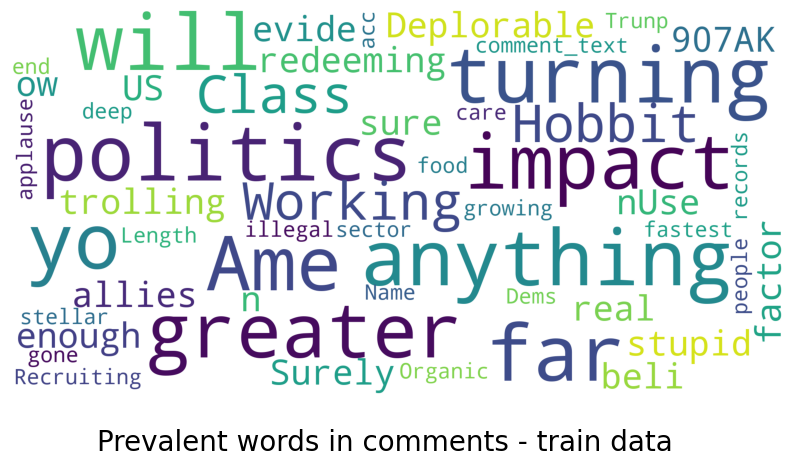

In [33]:
show_wordcloud(train_df['comment_text'].sample(20000), title = 'Prevalent words in comments - train data')

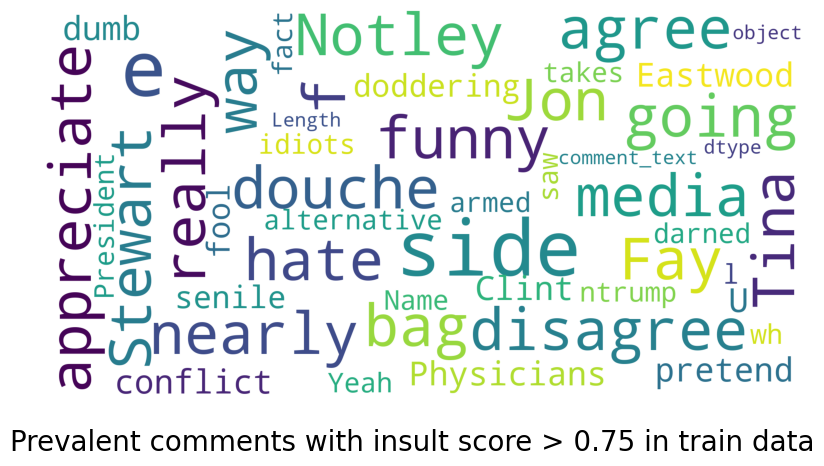

In [34]:
show_wordcloud(train_df.loc[train_df['insult'] > 0.75]['comment_text'].sample(20000), 
               title = 'Prevalent comments with insult score > 0.75 in train data')

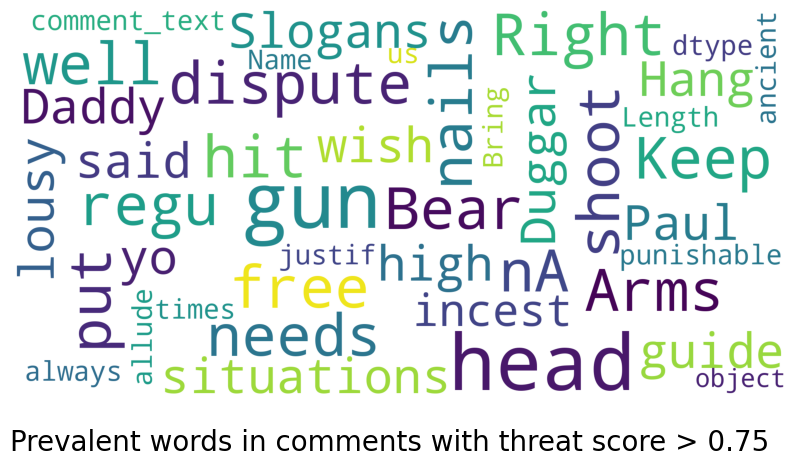

In [35]:
show_wordcloud(train_df.loc[train_df['threat'] > 0.75]['comment_text'], 
               title = 'Prevalent words in comments with threat score > 0.75')

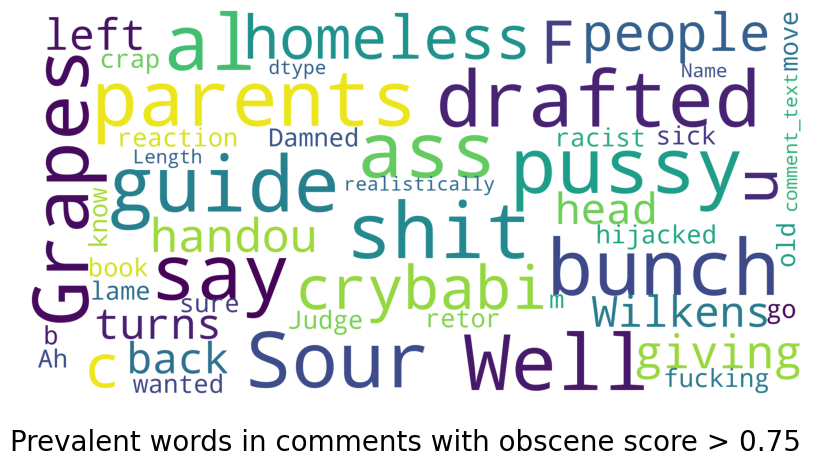

In [36]:
show_wordcloud(train_df.loc[train_df['obscene'] > 0.75]['comment_text'], 
               title = 'Prevalent words in comments with obscene score > 0.75')

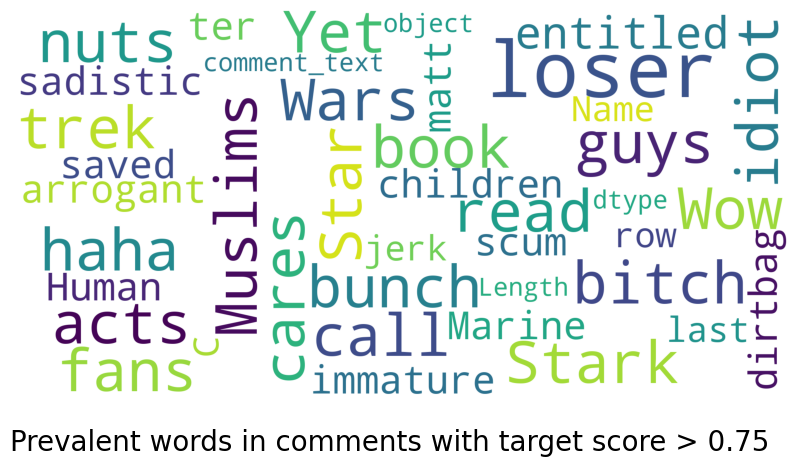

In [37]:
show_wordcloud(train_df.loc[train_df['target'] > 0.75]['comment_text'], 
               title = 'Prevalent words in comments with target score > 0.75')

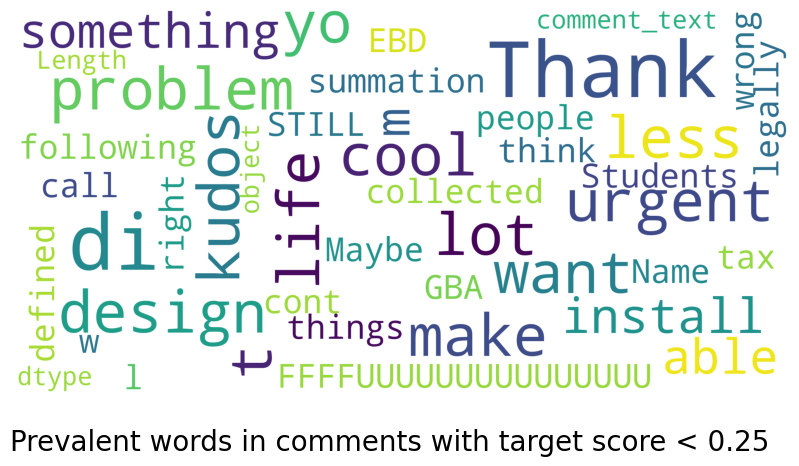

In [38]:
show_wordcloud(train_df.loc[train_df['target'] < 0.25]['comment_text'], 
               title = 'Prevalent words in comments with target score < 0.25')

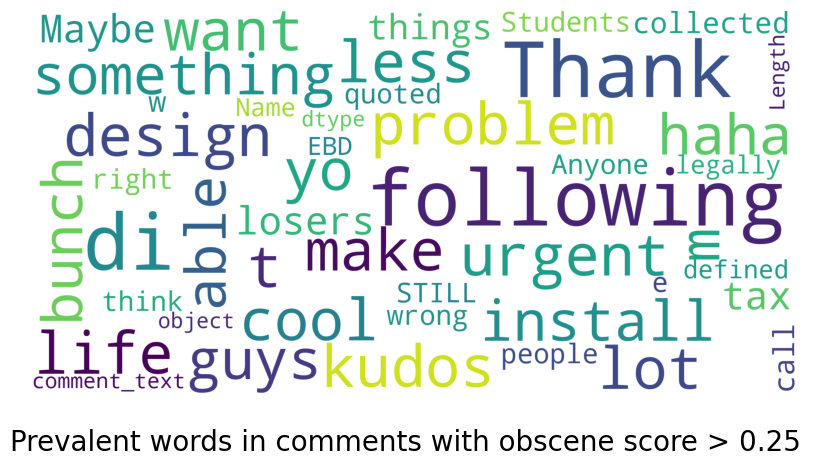

In [39]:
show_wordcloud(train_df.loc[train_df['obscene'] < 0.25]['comment_text'], 
               title = 'Prevalent words in comments with obscene score > 0.25')

**Preprocessing Text and Train-Test Split**

In [40]:
stemmer = SnowballStemmer("english")
stop_words = set(stopwords.words('english'))
def preprocess(text_string):
    text_string = text_string.lower() # Convert everything to lower case.
    text_string = re.sub('[^A-Za-z0-9]+', ' ', text_string) # Remove special characters and punctuations
    
    x = text_string.split()
    new_text = []
    
    for word in x:
        if word not in stop_words:
            new_text.append(stemmer.stem(word))
            
    text_string = ' '.join(new_text)
    return text_string

In [1]:

train_df['comment_text'] = train_df['comment_text'].fillna('')
train_df['preprocessed_text'] = train_df['comment_text'].apply(preprocess)


NameError: name 'train_df' is not defined

In [ ]:
train_df.head()

In [ ]:
test_df['preprocessed_text'] = test_df['comment_text'].apply(preprocess)

In [ ]:
feature = train_df[['preprocessed_text']]
output = train_df[['target']]
X_train, X_cv, y_train, y_cv = train_test_split(feature, output)

print(X_train.shape)
print(X_cv.shape)
print(y_train.shape)
print(y_cv.shape)

In [ ]:
X_train.head()

In [ ]:
X_cv.head()

In [48]:
X_test = test_df[['preprocessed_text']]
X_test.head()

KeyError: "None of [Index(['preprocessed_text'], dtype='object')] are in the [columns]"

**Saving the files to csv so that we dont need to preprocess again.**

In [47]:
X_train.to_pickle('X_train.pkl')
X_cv.to_pickle('X_cv.pkl')
X_test.to_pickle('X_test.pkl')
y_train.to_pickle('y_train.pkl')
y_cv.to_pickle('y_cv.pkl')

NameError: name 'X_train' is not defined

# **TRAINING MODEL**

In [46]:
X_train = pd.read_pickle('X_train.pkl')
X_cv = pd.read_pickle('X_cv.pkl')
X_test = pd.read_pickle('X_test.pkl')
y_train = pd.read_pickle('y_train.pkl')
y_cv = pd.read_pickle('y_cv.pkl')

FileNotFoundError: [Errno 2] No such file or directory: 'X_train.pkl'

# 1.Bag Of Words (BoW)


In [ ]:
cnt_vec = CountVectorizer(ngram_range=(1,2), max_features=30000)
bow_train = cnt_vec.fit_transform(X_train['preprocessed_text'])
bow_cv = cnt_vec.transform(X_cv['preprocessed_text'])
bow_test = cnt_vec.transform(X_test['preprocessed_text'])

print(bow_train.shape)
print(bow_cv.shape)
print(bow_test.shape)

# 1.1 SGDRegressor:

In [ ]:
alpha = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
penalty = ['l1', 'l2']
xticks = []
tr_errors = []
cv_errors = []
best_model = None
best_error = 100
for a in alpha:
    for p in penalty:
        xticks.append(str(a) + ' ' + p)
        print(str(a) + ' ' + p + " :")
        
        model = SGDRegressor(alpha=a, penalty=p) 
        model.fit(bow_train, y_train) # Train
        
        preds = model.predict(bow_train) # Get predictions
        err = mean_squared_error(y_train['target'], preds) # Calculate error on trainset
        tr_errors.append(err)
        print("Mean Squared Error on train set: ", err)
        
        preds = model.predict(bow_cv) # Get predictions on CV set
        err = mean_squared_error(y_cv['target'], preds) # Calculate error on cv set
        cv_errors.append(err)
        print("Mean Squared Error on cv set: ", err)
        
        if err < best_error: # Get best model trained
            best_error = err
            best_model = model
        
        print("*"*50)

In [ ]:
plt.figure(figsize=(15,5))
plt.suptitle("Hyperparameters vs MSE")
plt.plot(range(len(alpha) * len(penalty)), tr_errors)
plt.plot(range(len(alpha) * len(penalty)), cv_errors)
plt.legend(['train', 'cv'])
plt.xticks(range(len(alpha) * len(penalty)), xticks, rotation=45)
plt.xlabel('Hyperparameter: alpha + penalty')
plt.ylabel('Mean Squared Error')
plt.show()


In [ ]:
best_model.get_params()

**1.1.2 Feature Importance:**

In [ ]:
feat_names = cnt_vec.get_feature_names_out()
weights = best_model.coef_
df = pd.DataFrame(data=weights, columns=['weights'], index=feat_names)
top_20_features = df.sort_values("weights", ascending=False).iloc[0:20,:]
print(top_20_features)


**1.2 Decision Trees:**

**1.2.1 Hyperparameter Tuning:**

In [ ]:
max_depth = [3, 5, 7]
min_samples = [10, 100, 1000]
xticks = []
tr_errors = []
cv_errors = []
best_model = None
best_error = 100
for d in max_depth:
    for samp in min_samples:
        xticks.append("Depth- " + str(d) + ' Min Samples leaf-' + str(samp))
        print("Depth- " + str(d) + ' Min Samples leaf-' + str(samp) + " :")
        
        model = DecisionTreeRegressor(max_depth=d, min_samples_leaf=samp)
        model.fit(bow_train, y_train) # Train
        
        preds = model.predict(bow_train) # Get predictions
        err = mean_squared_error(y_train['target'], preds) # Calculate error on trainset
        tr_errors.append(err)
        print("Mean Squared Error on train set: ", err)
        
        preds = model.predict(bow_cv) # Get predictions on CV set
        err = mean_squared_error(y_cv['target'], preds) # Calculate error on cv set
        cv_errors.append(err)
        print("Mean Squared Error on cv set: ", err)
        
        if err < best_error: # Get best model trained
            best_error = err
            best_model = model
        
        print("*"*50)

In [ ]:
plt.figure(figsize=(15,5))
plt.suptitle("Hyperparameters vs MSE")
plt.plot(range(len(max_depth) * len(min_samples)), tr_errors)
plt.plot(range(len(max_depth) * len(min_samples)), cv_errors)
plt.legend(['train', 'cv'])
plt.xticks(range(len(max_depth) * len(min_samples)), xticks, rotation=45)
plt.xlabel('Hyperparameter: max depth + min_samples_leaf')
plt.ylabel('Mean Squared Error')
plt.show()

In [ ]:
best_model.get_params()

**1.2.2 Feature Importance:**

In [ ]:
weights = best_model.feature_importances_
df = pd.DataFrame(data=weights, columns=['weights'], index=feat_names)
df.sort_values("weights", ascending=False).iloc[0:20,:]

**Term Frequency - Inverse Document Frequency (TFIDF) :**

In [ ]:
tfidf_vec = TfidfVectorizer(ngram_range=(1,2), max_features=30000)
tfidf_train = tfidf_vec.fit_transform(X_train['preprocessed_text'])
tfidf_cv = tfidf_vec.transform(X_cv['preprocessed_text'])
tfidf_test = tfidf_vec.transform(X_test['preprocessed_text'])

print(tfidf_train.shape)
print(tfidf_cv.shape)
print(tfidf_test.shape)

**3. Features for LSTM:**

In [44]:
import numpy as np
import pandas as pd
from tensorflow import keras

class LSTMFeaturization:
    
    def __init__(self):
        self.word_mapping = None
        self.total_words = None
    
    # Accepts a list of sentences and builds a vocabulary.
    def build_vocabulary(self, sentences):
        vocab = set()
        for x in sentences:
            for word in x.split():
                vocab.add(word)
        
        # Create a dictionary from vocabulary.
        vocab_dict = dict.fromkeys(vocab, 0)
        
        # Calculate count of each word.
        for x in sentences:
            for word in x.split():
                vocab_dict[word] += 1
                
        return vocab_dict
    
    # Accepts a dictionary (vocabulary) and gets the word number in dictionary format
    def get_mapping(self, vocab_dict):
        # Get the number of each word into the corpus.
        k = []
        v = []
        for keys,val in vocab_dict.items():
            k.append(keys)
            v.append(val)
            
        kv = np.vstack((k,v)).T
        df = pd.DataFrame(columns=["Word","Count"], data=kv)
        df['Count'] = df['Count'].astype('int')
        
        # Sort the dataframe to get the largest count at first place
        df.sort_values(by=['Count'], ascending=False, inplace=True)
        
        # Give numbering to the most frequent word as 1 then next as 2 and so on.
        df.reset_index(inplace=True)
        df['mapping'] = df.index + 1
        
        df.drop(columns=['index'], inplace=True)
        df.drop(columns=['Count'], inplace=True)
        
        # Convert to dictionary for easier processing.
        dictionary = dict(zip(df['Word'], df['mapping']))
        
        return dictionary
    
    # Accepts a list of sentences and generates vocabulary and word mappings.
    def fit(self, sentences):
        v = self.build_vocabulary(sentences)
        self.word_mapping = self.get_mapping(v)
        self.total_words = len(self.word_mapping)
        
    # Converts the sentences to number mappings.
    def transform(self, sentences, pad_length = 350):
        whole = [] # Stores mapping for all sentences
        for x in sentences: # for each sentence in list of sentences.
            part = []
            for word in x.split(): # for each word
                if word in self.word_mapping:
                    part.append(self.word_mapping[word])
            whole.append(part) # Append sentence.
        
        # Pad or truncate sublists to ensure fixed length
        whole = keras.preprocessing.sequence.pad_sequences(whole, maxlen=pad_length)
        
        return whole


In [45]:
lstmfeat = LSTMFeaturization()
lstmfeat.fit(X_train['preprocessed_text'])

NameError: name 'X_train' is not defined

In [ ]:
lstm_train = lstmfeat.transform(X_train['preprocessed_text'])
lstm_test = lstmfeat.transform(X_test['preprocessed_text'])
lstm_cv = lstmfeat.transform(X_cv['preprocessed_text'])

In [ ]:
print(lstm_train.shape)
print(lstm_cv.shape)
print(lstm_test.shape)

In [ ]:
np.save('lstm_train.npy', lstm_train)
np.save('lstm_cv.npy', lstm_cv)
np.save('lstm_test.npy', lstm_test)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

embedding_vecor_length = 100
total_words = lstmfeat.total_words
model = Sequential()
model.add(Embedding(total_words, embedding_vecor_length, input_length=350))
model.add(LSTM(128, return_sequences=True))
model.add(LSTM(128))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=['mse'])
print(model.summary())


In [ ]:
input_text='I hate you'
predictions = model.predict(input_data)
print(predictions)

In [ ]:
tf.config.list_physical_devices('GPU')

In [ ]:
filepath="weights-improvement-{epoch:02d}-{val_loss:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [ ]:
history = model.fit(lstm_train, y_train, epochs=5,
                    batch_size=2048, validation_data=(lstm_cv, y_cv), verbose=1, callbacks=callbacks_list)


In [ ]:
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)